## Import Semua Packages/Library yang Digunakan

In [ ]:
# Libraries Utama
import os
import zipfile
import random
import pathlib
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Pemrosesan Gambar
import cv2
from PIL import Image
import skimage
from skimage import io, transform, exposure, util
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras import Model, layers, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import (InputLayer, Conv2D, SeparableConv2D,
                                   MaxPooling2D, Dense, Flatten, Dropout,
                                   BatchNormalization,GlobalAveragePooling2D)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,Callback
import io
from keras.layers import TFSMLayer
from IPython.display import display
import kagglehub
# Utilitas Lain
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

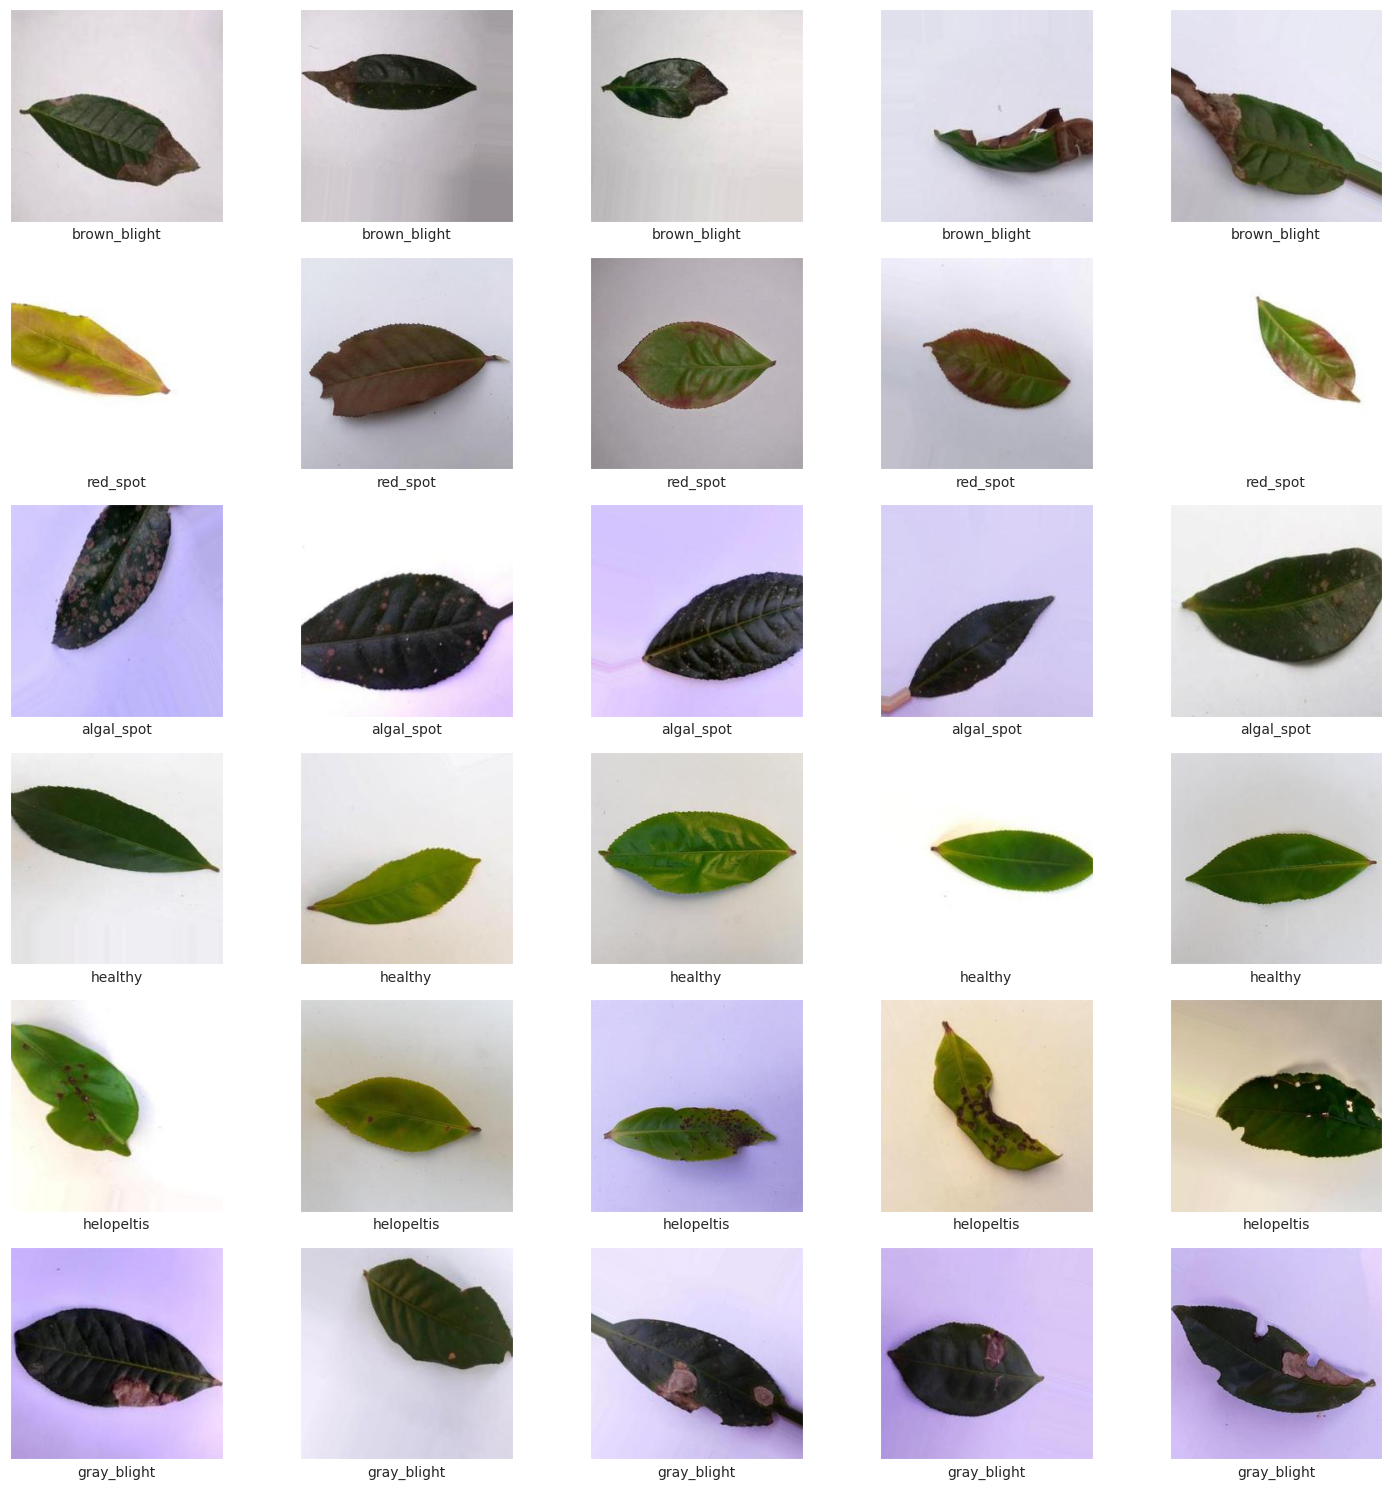

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
scene_image = {}

# Tentukan path sumber train
path = kagglehub.dataset_download("pavantejamedi/tea-leaf-disease-detection-data")

path_sub = os.path.join(path, "Tea Leaf Disease Dataset")
for i in os.listdir(path_sub):
    scene_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.


# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(scene_image.keys()), 5, figsize=(15, 15))
for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(scene_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()


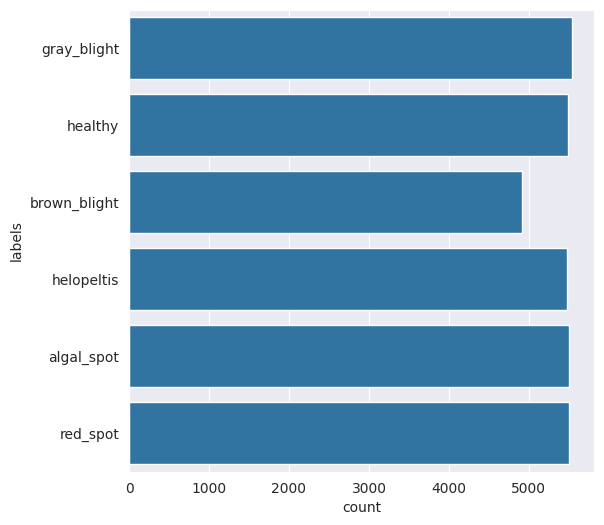

In [ ]:
# Define source path
scene_path = path
# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(scene_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random
import shutil
from tqdm import tqdm

# ================== FIXED AUGMENTATION FUNCTIONS ==================
def normalize_image(img):
    """Normalize image to [0,1] range"""
    return img / 255.0

def denormalize_image(img):
    """Convert image back to [0,255] range"""
    return (img * 255).astype(np.uint8)

def anticlockwise_rotation(img):
    img = tf.image.resize(img, IMG_SIZE)
    return tf.image.rot90(img, k=random.randint(1,3))

def clockwise_rotation(img):
    img = tf.image.resize(img, IMG_SIZE)
    return tf.image.rot90(img, k=4-random.randint(1,3))

def flip_up_down(img):
    img = tf.image.resize(img, IMG_SIZE)
    return tf.image.flip_up_down(img)

def add_brightness(img):
    img = tf.image.resize(img, IMG_SIZE)
    return tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.3))

def sheared(img):
    img = tf.image.resize(img, IMG_SIZE)
    img_np = img.numpy()

    # ImageDataGenerator with proper configuration
    datagen = ImageDataGenerator(
        shear_range=0.2,
        fill_mode='constant',
        cval=0.0,
        rescale=1.0  # Important: prevent auto-rescaling
    )

    # Process image in batch
    batch = np.expand_dims(img_np, 0)
    result = next(datagen.flow(batch, batch_size=1))
    return tf.convert_to_tensor(result[0], dtype=tf.float32)

def warp_shift(img):
    img = tf.image.resize(img, IMG_SIZE)
    img_np = denormalize_image(img.numpy())  # Convert to uint8 for OpenCV operations

    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='constant',
        cval=0.0,
        rescale=1.0/255.0  # Normalize back to [0,1]
    )

    batch = np.expand_dims(img_np, 0)
    result = next(datagen.flow(batch, batch_size=1))
    return tf.convert_to_tensor(result[0], dtype=tf.float32)

# ================== FIXED AUGMENTATION PIPELINE ==================
transformations = {
    'anticlockwise_rotation': anticlockwise_rotation,
    'clockwise_rotation': clockwise_rotation,
    'flip_up_down': flip_up_down,
    'add_brightness': add_brightness,
    'sheared': sheared,
    'warp_shift': warp_shift
}

def process_image(image_path):
    # Load and preprocess
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = normalize_image(img.astype(np.float32))  # Normalize to [0,1]
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    # Apply 1-2 random transformations
    for _ in range(random.randint(1, 2)):
        t_func = random.choice(list(transformations.values()))
        img = t_func(img)

    # Post-processing
    img = tf.clip_by_value(img, 0.0, 1.0).numpy()  # Ensure valid range
    img = denormalize_image(img)  # Convert to [0,255]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert back to BGR

    return img

# ================== FIXED MAIN LOGIC ==================
images_path = path_sub
augmented_path = "tea/dataset_augmentation/"
os.makedirs(augmented_path, exist_ok=True)

target_per_class = 6000

for class_name in tqdm(os.listdir(images_path)):
    class_src_dir = os.path.join(images_path, class_name)
    class_dst_dir = os.path.join(augmented_path, class_name)
    os.makedirs(class_dst_dir, exist_ok=True)


    original_images = [f for f in os.listdir(class_src_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    original_images = random.sample(original_images, min(target_per_class, len(original_images)))
    for file in original_images:
        shutil.copy2(os.path.join(class_src_dir, file), os.path.join(class_dst_dir, file))

    current_count = len(original_images)
    images_to_generate = target_per_class - current_count


    if images_to_generate <= 0:
        print(f" Kelas {class_name} sudah memiliki: {current_count} gambar, tidak perlu augmentasi.")
        continue

    print(f" Augmentasi class {class_name}: {images_to_generate} gambar")

    i = 1
    while i <= images_to_generate:
        try:
            # Select random source image
            original_file = random.choice(original_images)  # Nama file asli (misal: 'img123.jpg')
            original_name = os.path.splitext(original_file)[0]  # Hapus ekstensi (menjadi 'img123')

            src_path = os.path.join(class_src_dir, original_file)

            # Process and save
            augmented_img = process_image(src_path)
            save_path = os.path.join(class_dst_dir, f"{original_name}_aug_{i}.jpg")
            cv2.imwrite(save_path, augmented_img)
            i += 1

        except Exception as e:
            print(f"Error processing {src_path}: {str(e)}")

  0%|          | 0/6 [00:00<?, ?it/s]

 Augmentasi class brown_blight: 1092 gambar


 17%|█▋        | 1/6 [00:13<01:08, 13.61s/it]

 Augmentasi class red_spot: 495 gambar


 33%|███▎      | 2/6 [00:21<00:41, 10.49s/it]

 Augmentasi class algal_spot: 503 gambar


 50%|█████     | 3/6 [00:29<00:27,  9.26s/it]

 Augmentasi class healthy: 508 gambar


 67%|██████▋   | 4/6 [00:40<00:19,  9.69s/it]

 Augmentasi class helopeltis: 518 gambar


 83%|████████▎ | 5/6 [00:48<00:09,  9.28s/it]

 Augmentasi class gray_blight: 463 gambar


100%|██████████| 6/6 [01:00<00:00, 10.08s/it]


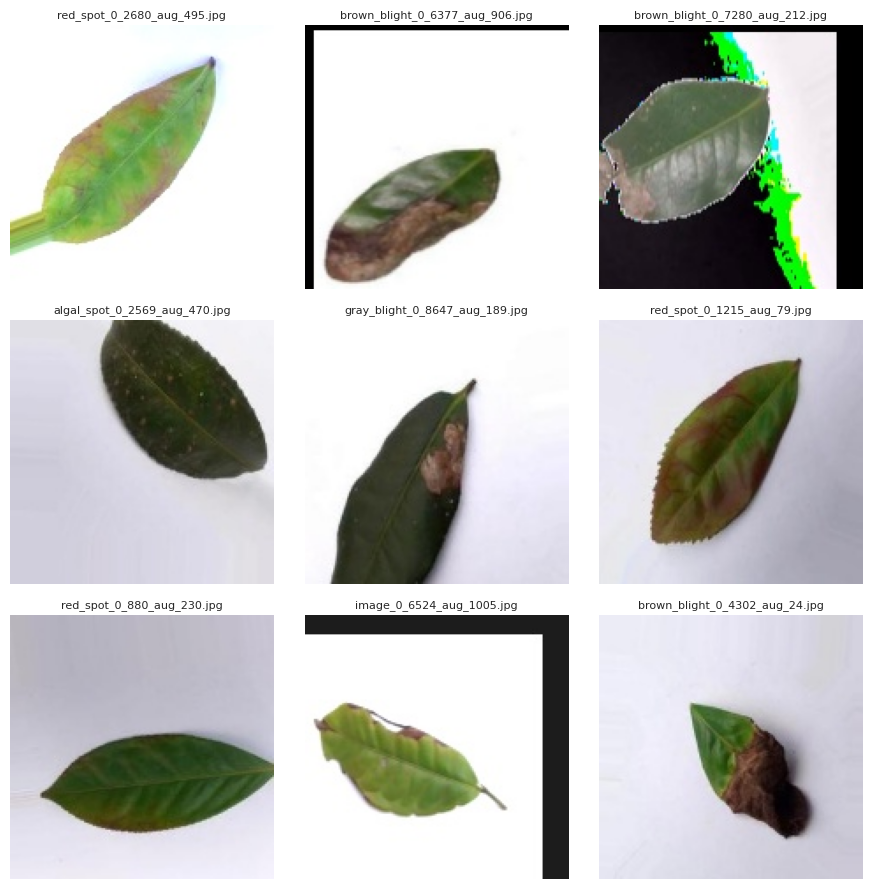

In [ ]:

# Collect all augmented images across classes
aug_images = []
for class_dir in os.listdir(augmented_path):
    class_dir_path = os.path.join(augmented_path, class_dir)
    if os.path.isdir(class_dir_path):
        for fname in os.listdir(class_dir_path):
          lower_fname = fname.lower()
          if "aug" in lower_fname and lower_fname.endswith((".jpg", ".png", ".jpeg")):
              aug_images.append(os.path.join(class_dir_path, fname))

# Sample up to 9 images
sampled_images = random.sample(aug_images, min(9, len(aug_images)))

# Display in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for ax, img_path in zip(axes.flatten(), sampled_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(os.path.basename(img_path), fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!zip -r augmented_dataset.zip /content/tea/dataset_augmentation


Output streaming akan dipotong hingga 5000 baris terakhir.
  adding: content/tea/dataset_augmentation/red_spot/red_spot_0_1610.jpg (deflated 4%)
  adding: content/tea/dataset_augmentation/red_spot/20211225_231325.jpg (deflated 3%)
  adding: content/tea/dataset_augmentation/red_spot/red_spot_0_931.jpg (deflated 4%)
  adding: content/tea/dataset_augmentation/red_spot/20211227_160444.jpg (deflated 4%)
  adding: content/tea/dataset_augmentation/red_spot/red_spot_0_6683.jpg (deflated 3%)
  adding: content/tea/dataset_augmentation/red_spot/red_spot_0_9711.jpg (deflated 4%)
  adding: content/tea/dataset_augmentation/red_spot/red_spot_0_5380.jpg (deflated 5%)
  adding: content/tea/dataset_augmentation/red_spot/red_spot_0_5171.jpg (deflated 5%)
  adding: content/tea/dataset_augmentation/red_spot/red_spot_0_105.jpg (deflated 12%)
  adding: content/tea/dataset_augmentation/red_spot/red_spot_0_8782.jpg (deflated 4%)
  adding: content/tea/dataset_augmentation/red_spot/red_spot_0_4543.jpg (deflated 

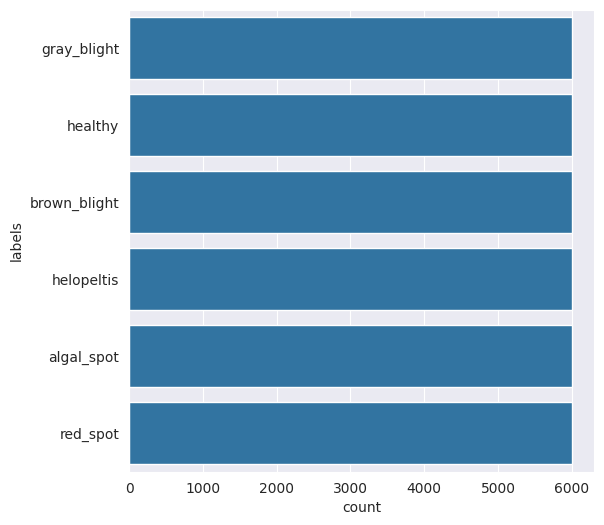

In [ ]:
# Definisikan path sumber
dataset_path = augmented_path

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)